<h1>Advanced Data Mining (CSc8740) - Assignment 2</h1>
<h4>Instructor: Dr. Berkay Aydin - Spring 2024</h4>
<h4>Student name: Reza Mansouri - Panther #: 002784647</h4>

# Packages

I will use `tslearn` for downloading the datasets and `aeon` to access the implemented classifers.

In [ ]:
!pip install -q -U tslearn
!pip install -q -U aeon

In [178]:
import aeon
import tslearn
import numpy as np
from pprint import pprint
import pandas as pd   # only for showing metadata
from tqdm import tqdm # for showing progress bars
from tslearn.datasets import UCR_UEA_datasets

# Data preparation

These datasets are all univariate and relatively small.

In [152]:
dataset_names = [
    'ECG200',
    'Car',
    'Chinatown',
    'DistalPhalanxOutlineAgeGroup',
    'DistalPhalanxTW',
    'MiddlePhalanxTW',
    'MiddlePhalanxOutlineAgeGroup',
    'Fish',
    'ProximalPhalanxOutlineAgeGroup',
    'ProximalPhalanxTW'
 ]

In [ ]:
loader = UCR_UEA_datasets()

## Downloading the datasets

`datasets` list will contain the `(name, X, y)` tuples.

In [171]:
datasets = []
info = {'dataset': [], 'size': [], 'length': [], 'n_classes': []}
for name in dataset_names:
    try:
        X_train, y_train, X_test, y_test = loader.load_dataset(name)
        X = np.concatenate((X_train, X_test)).squeeze()
        y = np.concatenate((y_train, y_test))
        datasets.append((name, X, y))
        info['dataset'].append(name)
        info['size'].append(X.shape[0])
        info['length'].append(X.shape[1])
        info['n_classes'].append(len(np.unique(y)))
    except:
        print(name, 'failed')
pd.DataFrame(info)

,dataset,size,length,n_classes
0,ECG200,200,96,2
1,Car,120,577,4
2,Chinatown,363,24,2
3,DistalPhalanxOutlineAgeGroup,539,80,3
4,DistalPhalanxTW,539,80,6
5,MiddlePhalanxTW,553,80,6
6,MiddlePhalanxOutlineAgeGroup,554,80,3
7,Fish,350,463,7
8,ProximalPhalanxOutlineAgeGroup,605,80,3
9,ProximalPhalanxTW,605,80,6


# Helper functions

Some utility functions I implemented.

## 10-fold data splitter

This function will return indices of corresponding instances for 10 folds, to be used in cross validation.

In [ ]:
def ten_fold_indices(n):
    fold_size = n // 10
    remainder = n % 10
    indices = np.arange(n)
    fold_indices = []
    start = 0
    for i in range(10):
        end = start + fold_size
        if i < remainder:
            end += 1
        fold_indices.append(indices[start:end])
        start = end
    return fold_indices

Testing...

In [ ]:
ten_fold_indices(22)

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7]),
 array([8, 9]),
 array([10, 11]),
 array([12, 13]),
 array([14, 15]),
 array([16, 17]),
 array([18, 19]),
 array([20, 21])]

## Accuracy measure:

In [ ]:
def accuracy(y_hat, y):
    return np.sum(y_hat == y) / len(y)

Testing...

In [ ]:
accuracy(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

0.9

## Fit and test

This function will fit a model on training data and measure the accuracy on testing data. The model is `cloned` so that the parameters are re-initialized, regardless of previous trainings, i.e., the `model` instance itself is never fit.

In [ ]:
def fit_and_test(model, X_train, y_train, X_test, y_test):
    model_temp = model.clone()
    model_temp.fit(X_train, y_train)
    y_hat = model_temp.predict(X_test)
    return accuracy(y_hat, y_test)

## Aggregate

This function performs 10-k cross validation for a model on a dataset, using `fit_and_test` and `ten-fold-indices`. It considers each fold as a testing set and the rest as the training set, in each iteration, and returns the mean accuracy across all folds.

In [ ]:
def aggregate(model, X, y):
    fold_indices = ten_fold_indices(len(X))
    accuracies = []
    for test_indices in fold_indices:
        X_test, y_test = X[test_indices], y[test_indices]
        X_train, y_train = X[~test_indices], y[~test_indices]
        accuracy = fit_and_test(model, X_train, y_train, X_test, y_test)
        accuracies.append(accuracy)
    return np.mean(accuracies)

# Experiments

## Models

My four chosen classifiers chosen from dictionary, feature, shapelet and interval based categories are, BOSSEnsemble, Summary, RDST, and TimeSeriesForest.

In [ ]:
from aeon.classification.dictionary_based import BOSSEnsemble
from aeon.classification.feature_based import SummaryClassifier
from aeon.classification.shapelet_based import RDSTClassifier
from aeon.classification.interval_based import TimeSeriesForestClassifier

There is a deprecation warning popping up in the aeon library during training that I will suppress here.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

`n_jobs=-1` means to use all the processing cores available. The rest of the hyperparameters are left as their default values.

In [167]:
models = [
    BOSSEnsemble(n_jobs=-1),
    SummaryClassifier(),
    RDSTClassifier(n_jobs=-1),
    TimeSeriesForestClassifier(n_jobs=-1)
]

## Training and testing
The following loop will get the 40 mean accuracies, for each dataset and for each model.

In [172]:
results = []
for dataset_name, X, y in tqdm(datasets):
    dataset_results = []
    for model in models:
        mean_accuracy = aggregate(model, X, y)
        dataset_results.append(mean_accuracy)
    results.append(dataset_results)

# Comparison

Here are the mean accuracies of each classifier for each dataset, across 10 folds for testing.

In [191]:
print('\t\tboss\tsummary\trdst\ttsf')
for i, dataset_results in enumerate(results):
    print('dataset', i+1, end='\t')
    for j, model_result in enumerate(dataset_results):
        print(f'{model_result:.3f}', end='\t')
    print()

		boss	summary	rdst	tsf
dataset 1	0.765	0.675	0.810	0.780	
dataset 2	0.583	0.333	0.725	0.567	
dataset 3	0.502	0.496	0.513	0.513	
dataset 4	0.697	0.721	0.710	0.745	
dataset 5	0.598	0.567	0.587	0.608	
dataset 6	0.453	0.467	0.474	0.478	
dataset 7	0.667	0.685	0.701	0.681	
dataset 8	0.854	0.369	0.877	0.623	
dataset 9	0.578	0.588	0.689	0.598	
dataset 10	0.711	0.676	0.689	0.729	


## Critical Difference diagram

In [175]:
from aeon.visualisation import plot_critical_difference

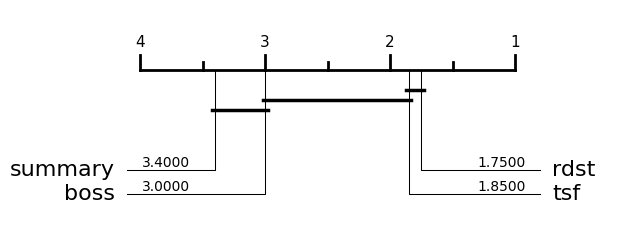

In [194]:
_ = plot_critical_difference(results, ['boss', 'summary', 'rdst', 'tsf'])